In [ ]:
# Data source: 
https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

# Data exploration

## Data preprocessing

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

c:\Users\Patricia Avram\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data\insurance.xls")
print("Shape:", df.shape)
display(df.head())
df.info()
df.describe() # this shows there are no null values in this dataset

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
# Checking for categorical variables: XGBoost cannot use them
print("Data types in the original dataset:")
print(df.dtypes) 
# We notice categorial variables to transform into factors

# Checking range of unique values
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n🔹 {col} — unique values:")
    print(df[col].unique())


Data types in the original dataset:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

🔹 sex — unique values:
['female' 'male']

🔹 smoker — unique values:
['yes' 'no']

🔹 region — unique values:
['southwest' 'southeast' 'northwest' 'northeast']


In [ ]:
eda_report = sv.analyze(df, target_feat='charges')
eda_report.show_html('reports\health_insurance_EDA.html')

In [4]:
from sklearn.preprocessing import LabelEncoder

# The variables to encode are sex, smoker, and region
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])          # male=1, female=0
df['smoker'] = le.fit_transform(df['smoker'])    # yes=1, no=0

# region needs to be one hot encoded into different columns
df = pd.get_dummies(df, columns=['region'], drop_first=True)


In [5]:
print("Data types in the transformed dataset:")
print(df.dtypes) 
# Notice 3 columns for region instead of 4 to avoid multicollinearity

Data types in the transformed dataset:
age                   int64
sex                   int32
bmi                 float64
children              int64
smoker                int32
charges             float64
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object


In [6]:
# Export cleaned data in the data folder
df.to_csv("data\cleaned_insurance.csv", index=False)

## Additional Visualisations

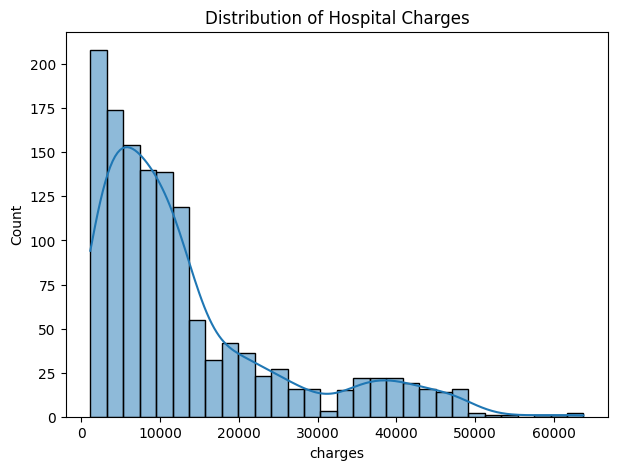

In [6]:
plt.figure(figsize=(7,5))
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Hospital Charges")
plt.xlabel("charges")
plt.show()

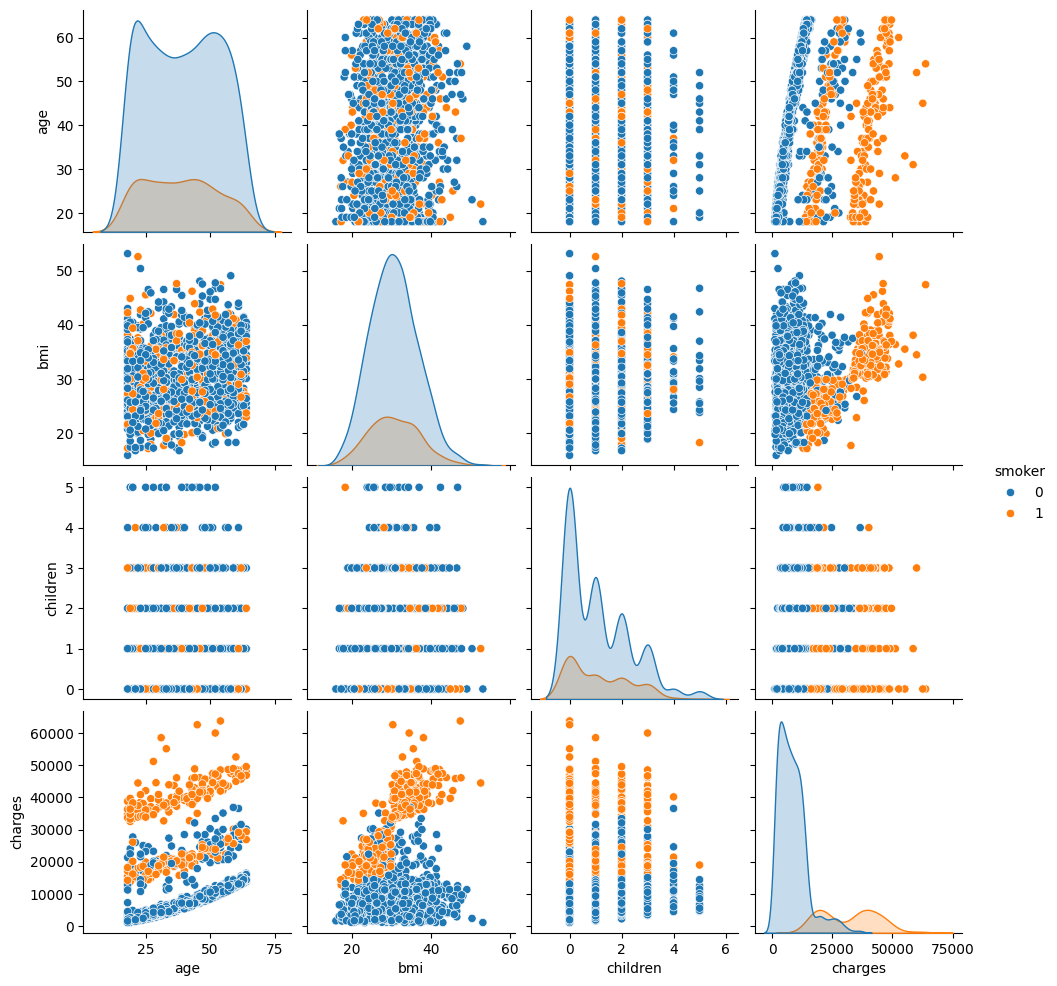

In [7]:
sns.pairplot(df[['age', 'bmi', 'children', 'charges', 'smoker']], 
             hue='smoker', diag_kind='kde')
plt.show()

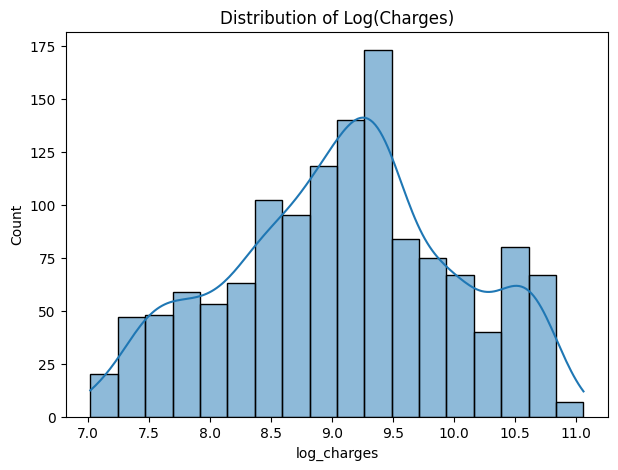

In [8]:
# exploration of log-transformation
df['log_charges'] = np.log(df['charges'])

plt.figure(figsize=(7,5))
sns.histplot(df['log_charges'], kde=True)
plt.title("Distribution of Log(Charges)")
plt.show()

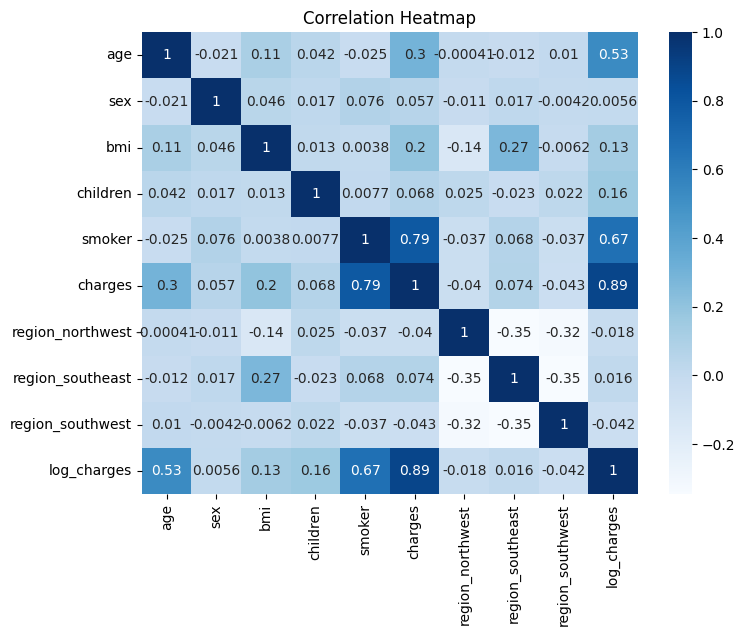

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

C:\Users\Patricia Avram\AppData\Local\Temp\ipykernel_21460\405370583.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['region'].isin(['northeast', 'northwest', 'southeast', 'southwest'])],


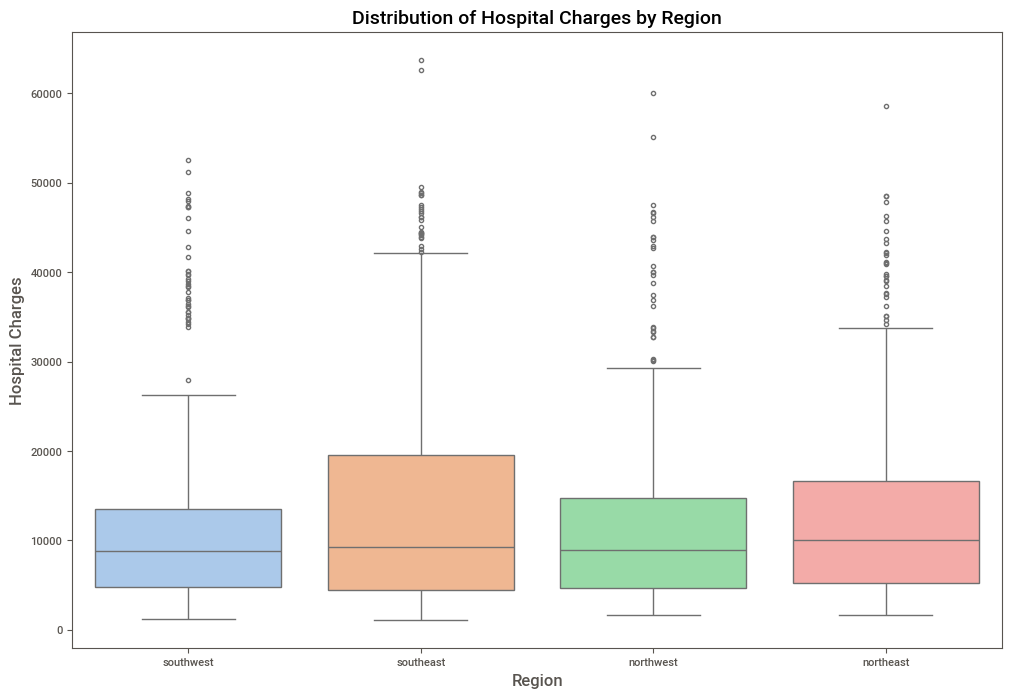

In [ ]:
def get_region(row):
    if row['region_northwest'] == 1:
        return 'northwest'
    elif row['region_southeast'] == 1:
        return 'southeast'
    elif row['region_southwest'] == 1:
        return 'southwest'
    else:
        return 'northeast'  # default if none of the dummies is 1

df['region'] = df.apply(get_region, axis=1)

plt.figure(figsize=(12,8))
sns.boxplot(data=df[df['region'].isin(['northeast', 'northwest', 'southeast', 'southwest'])],
            x='region', y='charges', palette='pastel')

plt.title("Distribution of Hospital Charges by Region", fontsize=14)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Hospital Charges", fontsize=12)
plt.show()

In [11]:
region_summary = df.groupby('region')['charges'].agg(['mean', 'median', 'std', 'count'])
print(region_summary)

                   mean        median           std  count
region                                                    
northeast  13406.384516  10057.652025  11255.803066    324
northwest  12417.575374   8965.795750  11072.276928    325
southeast  14735.411438   9294.131950  13971.098589    364
southwest  12346.937377   8798.593000  11557.179101    325


The distributions of the southeast hospitals has a higher median and larger spread, so a higher average hospital costs and more variability.
The southwest and northwest hospitals have a smaller box and a lower median which means more consistent and lower-cost patients